In [ ]:
!pip install -U keras

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"

import glob
import keras
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset

In [2]:
feature_columns = [
    'LeftElbowYaw', 'LeftElbowRoll', 'LeftShoulderRoll', 'LeftShoulderPitch',
    'origin_x', 'origin_y', 'origin_z',
    'goal_x', 'goal_y', 'goal_z'
]
output_columns = [
    'LeftElbowYaw', 'LeftElbowRoll', 'LeftShoulderRoll', 'LeftShoulderPitch'
]

data_folder = glob.glob(r"..\NaoPickAndPlaceDataNew\*\processed_step_10.csv")
feature_shape = (10, len(feature_columns))  # (window, features)
label_shape = (1, 1)  # (window, features)

cache_base_dir = "NaoCache"

column_ranges = {
    'LeftElbowYaw': (-120, 120), 'LeftElbowRoll': (-90, 0),
    'RightElbowYaw': (-120, 120), 'RightElbowRoll': (0, 90),
    'LeftShoulderRoll': (-45, 90), 'LeftShoulderPitch': (-120, 120),
    'RightShoulderRoll': (-90, 45), 'RightShoulderPitch': (-120, 120),
    'LeftWristX': (-1, 1), 'LeftWristY': (-1, 1), 'LeftWristZ': (0, 3),
    'RightWristX': (-1, 1), 'RightWristY': (-1, 1), 'RightWristZ': (0, 3),
    'LeftElbowX': (-1, 1), 'LeftElbowY': (-1, 1), 'LeftElbowZ': (0, 3),
    'RightElbowX': (-1, 1), 'RightElbowY': (-1, 1), 'RightElbowZ': (0, 3),
    'LeftShoulderX': (-1, 1), 'LeftShoulderY': (-1, 1), 'LeftShoulderZ': (0, 3),
    'RightShoulderX': (-1, 1), 'RightShoulderY': (-1, 1), 'RightShoulderZ': (0, 3),
    'origin_x': (0, 640), 'origin_y': (0, 480), 'origin_z': (0, 7),
    'goal_x': (0, 640), 'goal_y': (0, 480), 'goal_z': (0, 7)
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def normalize_columns(df):
    for column, (min_val, max_val) in column_ranges.items():
        df[column] = (df[column] - min_val) / (max_val - min_val)
        if min_val < 0:
            df[column] = 2 * df[column] - 1
    return df


class CustomDataset(Dataset):
    def __init__(self, data_folder, feature_columns, output_columns, label_shape, filter_value):
        self.data_folder = data_folder
        self.feature_columns = feature_columns
        self.output_columns = output_columns
        self.label_shape = label_shape
        self.filter_value = filter_value
        self.data = list(self.generator())

    def generator(self):
        for file in self.data_folder:
            df = pd.read_csv(file)
            df = df.dropna()
            df = normalize_columns(df)

            if 'is_grasped' in df.columns:
                control_column = 'is_grasped'
            elif 'direction' in df.columns:
                control_column = 'direction'
                self.feature_columns = [col for col in self.feature_columns if col not in ['goal_x', 'goal_y', 'goal_z']]

            if self.filter_value is not None:
                df = df[df[control_column] == self.filter_value]

            selected_features = df[self.feature_columns].values.astype(np.float64)
            raw_data = df[self.output_columns].values.astype(np.float64)
            num_data = len(df)

            for skip in range(5, 100, 10):
                for i in range(0, num_data - 1):
                    if i < (feature_shape[0] - 1) * skip:
                        features = selected_features[:i + 1][::-1][::skip][::-1]
                        num_rows, num_columns = features.shape
                        num_rows_to_add = feature_shape[0] - num_rows
                        new_rows_array = np.full((num_rows_to_add, num_columns), 0)
                        features = np.concatenate((new_rows_array, features), axis=0)
                    else:
                        features = selected_features[i - ((feature_shape[0] - 1) * skip):i + 1][::-1][::skip][::-1]

                    next_control_value = df[control_column].values[i]

                    diff = 0 if i + skip < num_data - 1 else -len(df) + i + skip + 2
                    next_label = raw_data[i + 1 + skip - diff:i + 1 + skip - diff + self.label_shape[0]]
                    labels = next_label.squeeze(0)
                    labels = torch.tensor(labels, dtype=torch.float64, device=device)

                    yield [torch.tensor(features, dtype=torch.float64, device=device),
                           torch.tensor(skip, dtype=torch.int16, device=device),
                           torch.tensor(next_control_value, dtype=torch.int16, device=device)], labels

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)



def create_dataset(data_folder, output_columns, label_shape, is_grasped, cache_path=None):
    if cache_path and os.path.exists(cache_path):
        dataset = torch.load(cache_path)
    else:
        dataset = CustomDataset(data_folder, feature_columns, output_columns, label_shape, is_grasped)
    return dataset

In [4]:
def split_dataset(dataset, train_size, batch_size, shuffle=True):
    dataset_size = len(dataset)
    train_size = int(dataset_size * train_size)

    indices = list(range(dataset_size))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [5]:
def train_model_for_output(data_folder, output_column, feature_shape, label_shape, is_grasped, cache_dir, split_ratio=0.8, batch_size=4096):
    dataset = create_dataset(data_folder, [output_column], label_shape, is_grasped, cache_path=cache_dir)
    dataset_train, dataset_val = split_dataset(dataset, split_ratio, batch_size)
    
    initializer = keras.initializers.GlorotUniform(seed=42)

    # Input layers
    input_layer = keras.layers.Input(shape=feature_shape)
    step_input = keras.layers.Input(shape=(1,))
    is_grasped_input = keras.layers.Input(shape=(1,))
    
    n = 64
    
    lstm_out = keras.layers.LSTM(n * 4, return_sequences=False,
                                                           kernel_initializer=initializer)(input_layer)
    
    step_embedding = keras.layers.Embedding(input_dim=100, output_dim=n)(step_input)
    is_grasped_embedding = keras.layers.Embedding(input_dim=3, output_dim=n)(is_grasped_input)
    
    step_embedding_flat = keras.layers.Flatten()(step_embedding)
    is_grasped_embedding_flat = keras.layers.Flatten()(is_grasped_embedding)

    x = keras.layers.Concatenate()([lstm_out, step_embedding_flat, is_grasped_embedding_flat])
    
    output_layer = keras.layers.Dense(label_shape[0], activation='linear', kernel_initializer=initializer)(x)
    
    model = keras.models.Model(inputs=[input_layer, step_input, is_grasped_input], outputs=output_layer)
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001, clipnorm=1.0),
                  loss='mse', metrics=['mae'])
    
    model.summary()

    model_dir = "../model"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.0000001)
    early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=50, min_delta=1e-5, verbose=1, restore_best_weights=True)
    prefix = 'all' if is_grasped is None else 'grasp' if is_grasped == -1 else 'drop'
    model_checkpoint = keras.callbacks.ModelCheckpoint(f"{model_dir}/best_model_{output_column}_{prefix}.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min', initial_value_threshold=1.0)
    
    history = model.fit(dataset_train, validation_data=dataset_val, epochs=3000, callbacks=[lr_reducer, early_stop, model_checkpoint])
    
    plt.plot(np.log(history.history['loss']), label='Training Log Loss')
    plt.plot(np.log(history.history['val_loss']), label='Validation Log Loss')
    plt.title(f'Training and Validation Loss for {output_column}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    torch.cuda.empty_cache()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 64)     │      6,400 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 64)     │        192 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    273,408 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        385 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 280,385 (1.07 MB)

 Trainable params: 280,385 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1244 - mae: 0.2926
Epoch 1: val_loss improved from 1.00000 to 0.06534, saving model to ../model/best_model_LeftElbowYaw_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1228 - mae: 0.2903 - val_loss: 0.0653 - val_mae: 0.2049 - learning_rate: 0.0010
Epoch 2/3000
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0632 - mae: 0.1989
Epoch 2: val_loss improved from 0.06534 to 0.05444, saving model to ../model/best_model_LeftElbowYaw_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0626 - mae: 0.1977 - val_loss: 0.0544 - val_mae: 0.1828 - learning_rate: 0.0010
Epoch 3/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0478 - mae: 0.1693
Epoch 3: val_loss improved from 0.05444 to 0.05425, saving model to ../model/best_model_LeftElbowYaw_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0476 - mae: 0.1691 - val_loss: 0.0542 - val_mae: 0.1831 - learning_rate: 0.0010
Epoch 4/3000
13/13 ━━━━━━━━━━━━

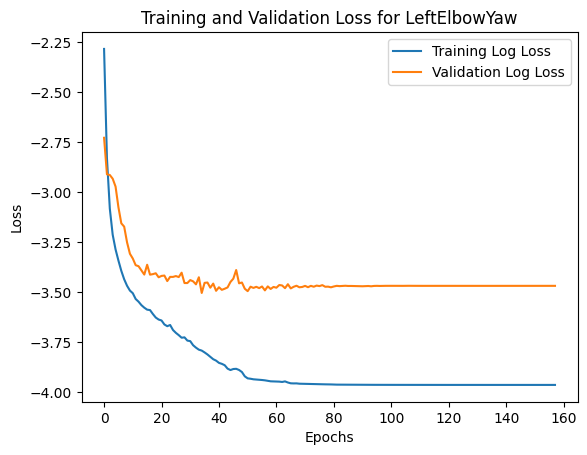

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 64)     │      6,400 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 64)     │        192 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    273,408 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 64)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 64)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        385 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 280,385 (1.07 MB)

 Trainable params: 280,385 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3000
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2752 - mae: 0.4476
Epoch 1: val_loss improved from 1.00000 to 0.17747, saving model to ../model/best_model_LeftElbowRoll_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2683 - mae: 0.4405 - val_loss: 0.1775 - val_mae: 0.3363 - learning_rate: 0.0010
Epoch 2/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1422 - mae: 0.3091
Epoch 2: val_loss improved from 0.17747 to 0.16878, saving model to ../model/best_model_LeftElbowRoll_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1416 - mae: 0.3082 - val_loss: 0.1688 - val_mae: 0.3245 - learning_rate: 0.0010
Epoch 3/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1112 - mae: 0.2663
Epoch 3: val_loss improved from 0.16878 to 0.16847, saving model to ../model/best_model_LeftElbowRoll_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1110 - mae: 0.2660 - val_loss: 0.1685 - val_mae: 0.3270 - learning_rate: 0.0010
Epoch 4/3000
13/13 ━━━━━━━━━

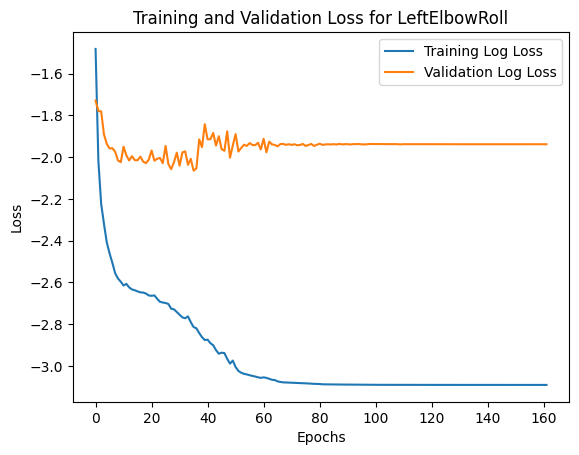

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 64)     │      6,400 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 64)     │        192 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    273,408 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 64)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 64)        │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 384)       │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        385 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 280,385 (1.07 MB)

 Trainable params: 280,385 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0434 - mae: 0.1641
Epoch 1: val_loss improved from 1.00000 to 0.05007, saving model to ../model/best_model_LeftShoulderRoll_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0430 - mae: 0.1634 - val_loss: 0.0501 - val_mae: 0.1887 - learning_rate: 0.0010
Epoch 2/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0290 - mae: 0.1407
Epoch 2: val_loss improved from 0.05007 to 0.04248, saving model to ../model/best_model_LeftShoulderRoll_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0290 - mae: 0.1403 - val_loss: 0.0425 - val_mae: 0.1666 - learning_rate: 0.0010
Epoch 3/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0252 - mae: 0.1277
Epoch 3: val_loss improved from 0.04248 to 0.03739, saving model to ../model/best_model_LeftShoulderRoll_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0252 - mae: 0.1277 - val_loss: 0.0374 - val_mae: 0.1555 - learning_rate: 0.0010
Epoch 4/3000
13/13 

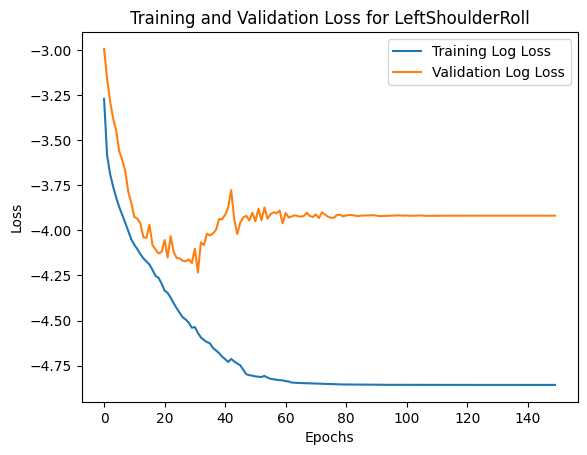

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 64)     │      6,400 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 64)     │        192 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    273,408 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 64)        │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 64)        │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 384)       │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ flatten_6[0][0],  │
│                     │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        385 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 280,385 (1.07 MB)

 Trainable params: 280,385 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0769 - mae: 0.2311
Epoch 1: val_loss improved from 1.00000 to 0.05306, saving model to ../model/best_model_LeftShoulderPitch_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0758 - mae: 0.2297 - val_loss: 0.0531 - val_mae: 0.2043 - learning_rate: 0.0010
Epoch 2/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0366 - mae: 0.1652
Epoch 2: val_loss improved from 0.05306 to 0.04166, saving model to ../model/best_model_LeftShoulderPitch_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0365 - mae: 0.1648 - val_loss: 0.0417 - val_mae: 0.1806 - learning_rate: 0.0010
Epoch 3/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0275 - mae: 0.1383
Epoch 3: val_loss improved from 0.04166 to 0.03841, saving model to ../model/best_model_LeftShoulderPitch_all.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0274 - mae: 0.1381 - val_loss: 0.0384 - val_mae: 0.1704 - learning_rate: 0.0010
Epoch 4/3000
13/

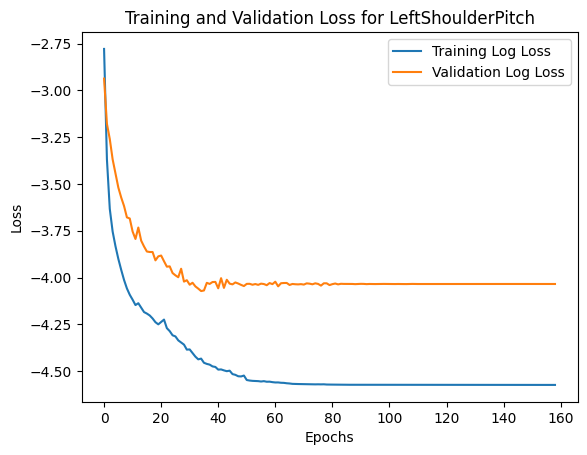

In [6]:
for output_column in output_columns:
    for has_controlled in [None]:
        cache_dir = f"{cache_base_dir}_{output_column}"
        train_model_for_output(data_folder, output_column, feature_shape, label_shape, has_controlled, cache_dir)

In [7]:
def restore_scale(predictions, label_ranges):
    restored_predictions = []
    for i, label in enumerate(label_ranges.keys()):
        min_val, max_val = label_ranges[label]
        normalized_value = predictions[0]

        if min_val < 0:
            original_value = ((normalized_value + 1) / 2) * (max_val - min_val) + min_val
        else:
            original_value = normalized_value * (max_val - min_val) + min_val

        restored_predictions.append(original_value)
    return np.array(predictions)
    
def calculate_prediction(dataset, model, label_ranges):
    all_predictions = {label: [] for label in label_ranges.keys()}
    all_actuals = {label: [] for label in label_ranges.keys()}

    for batch_data in dataset:
        features = batch_data[0]
        labels = batch_data[1].cpu().detach().numpy()

        predictions = np.array([p.cpu().detach().numpy() for p in model(features)])
        for i in range(len(features[0])):
            if features[1][i].cpu() != 5:
                continue
            restored_predictions = restore_scale(predictions[i], label_ranges)
            actual_labels = labels[i]
            restored_actual_labels = restore_scale(actual_labels, label_ranges)

            for j, label in enumerate(label_ranges.keys()):
                all_predictions[label].append(restored_predictions[j])
                all_actuals[label].append(restored_actual_labels[j])
    
    return all_predictions, all_actuals

def plot_predictions(predications, actuals):
    for label in predications.keys():
        plt.figure()
        
        plt.plot(actuals[label], label='Actual', linestyle='--')
        
        plt.plot(predications[label], label='Prediction')
        
        plt.title(f'Prediction vs Actual for {label}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

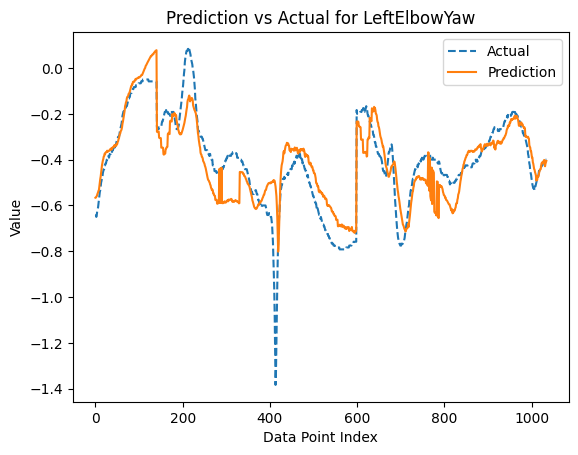

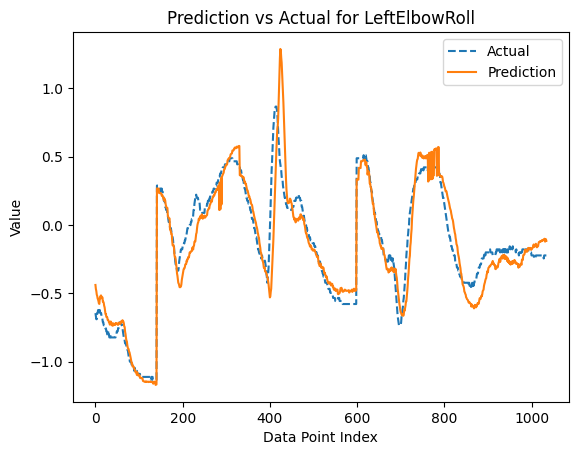

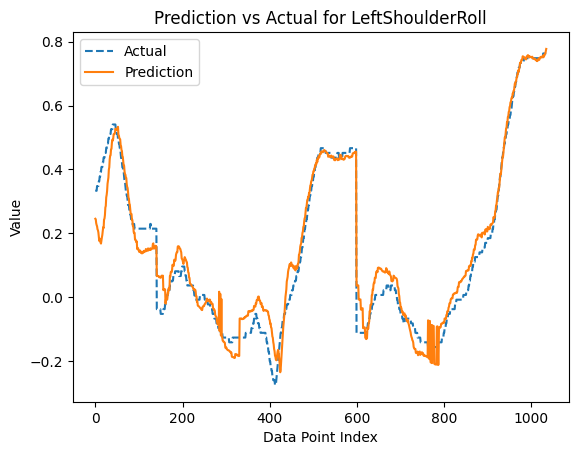

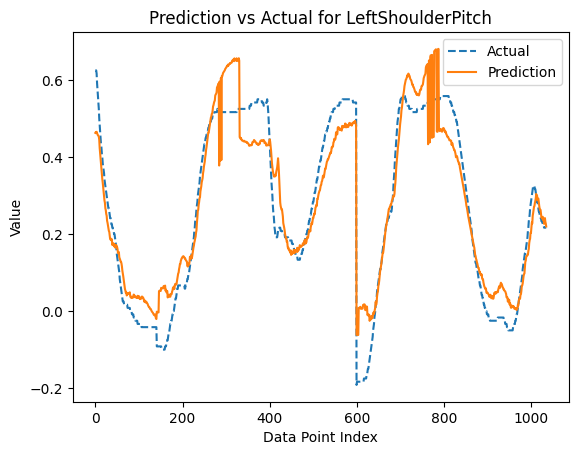

In [9]:
for output_column in output_columns:
    for has_controlled in [None]:
        prefix = 'all' if has_controlled is None else 'grasp' if has_controlled == -1 else 'drop'
        model = keras.models.load_model(f"../model/best_model_{output_column}_{prefix}.keras")
        label_ranges = {column: column_ranges[column] for column in [output_column] if column in column_ranges}
        dataset = create_dataset(data_folder, [output_column], label_shape, has_controlled, cache_path=f"NaoCache_{output_column}")
        dataset_train, dataset_val = split_dataset(dataset, 0.8, 1024, False)
        predications, actuals = calculate_prediction(dataset_val, model, label_ranges)
        plot_predictions(predications, actuals)